In [2]:
# inference-adult.py: inference on the adult dataset
# feature information (UCI): http://archive.ics.uci.edu/ml/datasets/adult
# but I think this Kaggle dataset is more informative: https://www.kaggle.com/datasets/uciml/adult-census-income

import numpy as np
import pandas as pd
import pickle
import subprocess
import os
# from summarytools import dfSummary
import matplotlib.pyplot as plt
from dython.nominal import associations
import seaborn as sns

FAKE_DATA_PATH = '/home/liu00980/Documents/multimodal/tabular/tab-ddpm/exp/adult/ddpm_cb_best'
TRUE_DATA_PATH = '/home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult/'

In [3]:
if not os.path.exists(os.path.join(FAKE_DATA_PATH, 'y_train.npy')):
    subprocess.run('python scripts/pipeline.py --config exp/adult/ddpm_cb_best/config.toml --sample')

# Get both fake and true data

In [3]:
# true data
X_num_test = np.load(os.path.join(TRUE_DATA_PATH, 'X_num_test.npy'))
X_cat_test = np.load(os.path.join(TRUE_DATA_PATH, 'X_cat_test.npy'))   
y_test = np.load(os.path.join(TRUE_DATA_PATH, 'y_test.npy'))            # wheter a person makes over 50K a year                  

col_names = ['y'] + ['x_num_' + str(i) for i in range(X_num_test.shape[1])] + ['x_cat_' + str(i) for i in range(X_cat_test.shape[1])]
truedf = pd.DataFrame(
    np.concatenate([y_test[:, None], X_num_test, X_cat_test], axis=1),
    columns = col_names
)

new_types = {col_name: 'category' if col_name.startswith(('y', 'x_cat')) else 'float' for col_name in col_names}
truedf = truedf.astype(new_types)

# dfSummary(pd.DataFrame(truedf))

In [4]:
# fake data
X_num_test_syn = np.load(os.path.join(FAKE_DATA_PATH, 'X_num_train.npy'))
X_cat_test_syn = np.load(os.path.join(FAKE_DATA_PATH, 'X_cat_train.npy'), allow_pickle=True)
y_test_syn = np.load(os.path.join(FAKE_DATA_PATH, 'y_train.npy'))                   

col_names = ['y'] + ['x_num_' + str(i) for i in range(X_num_test.shape[1])] + ['x_cat_' + str(i) for i in range(X_cat_test.shape[1])]
fakedf = pd.DataFrame(
    np.concatenate([y_test_syn[:, None], X_num_test_syn, X_cat_test_syn], axis=1),
    columns = col_names
)

new_types = {col_name: 'category' if col_name.startswith(('y', 'x_cat')) else 'float' for col_name in col_names}
fakedf = fakedf.astype(new_types)

# dfSummary(pd.DataFrame(fakedf))

# Compare distributions of selected features

In [5]:
# combine two dataframes and creqate a new column 'type' indicating whether a sample is true or fake
truedf['type'] = 'Raw'
fakedf['type'] = 'PASS'
mydf = pd.concat([truedf, fakedf], ignore_index=True)

new_types = {col_name: 'category' if col_name.startswith(('y', 'x_cat')) else 'float' for col_name in col_names}
mydf = mydf.astype(new_types)

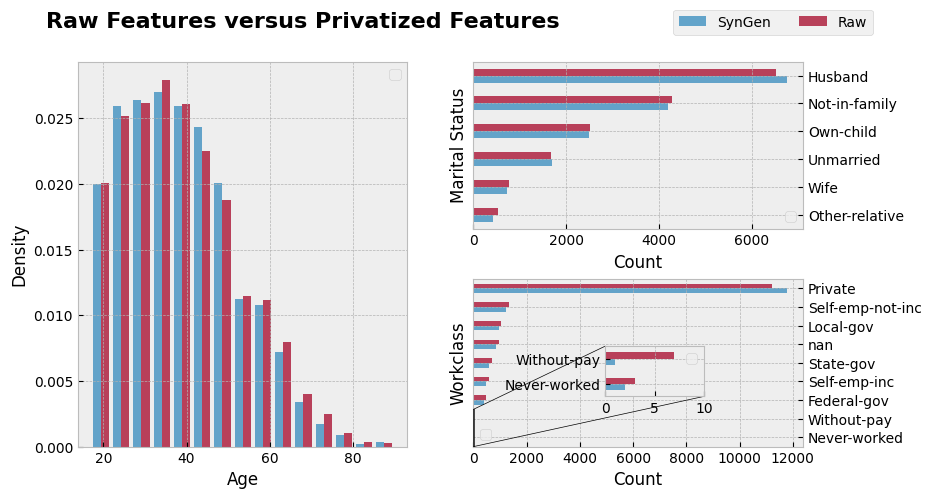

In [8]:
plt.style.use('bmh')
alpha = 0.75

fig = plt.figure(figsize=(30, 10))

 
ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=1, rowspan=2)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 1))
ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1))

ax1.hist([fakedf['x_num_0'], truedf['x_num_0']], label=['SynGen', 'Raw'], density=True, alpha=alpha, bins=15)
ax1.set_xlabel('Age')
ax1.set_ylabel('Density')
ax1.legend('')

(mydf
 .filter(['x_cat_4', 'type'])
 .pivot_table(index=['x_cat_4'], aggfunc='size', columns='type')
 .sort_values(by='Raw')
 .plot.barh(figsize=(10, 5), ax=ax2, alpha=alpha)
)
ax2.set_xlabel('Count')
ax2.set_ylabel('Marital Status')
ax2.legend('')
ax2.yaxis.tick_right()


(mydf
 .filter(['x_cat_0', 'type'])
 .pivot_table(index=['x_cat_0'], aggfunc='size', columns='type')
 .sort_values(by='Raw')
 .plot.barh(figsize=(10, 5), ax=ax3, alpha=alpha)
)
ax3.set_xlabel('Count')
ax3.set_ylabel('Workclass')
ax3.legend('')
ax3.yaxis.tick_right()


axins = ax3.inset_axes([0.4, 0.3, 0.3, 0.3])
  
(mydf
 .filter(['x_cat_0', 'type'])
 .pivot_table(index=['x_cat_0'], aggfunc='size', columns='type')
 .sort_values(by='Raw')
 .plot.barh(figsize=(10, 5), ax=axins, alpha=alpha)
)
axins.legend('')
axins.set_xlim(0, 10)
axins.set_ylim(-0.5, 1.5)
axins.set_xlabel('')
axins.set_ylabel('')
# axins.yaxis.tick_right()
  
ax3.indicate_inset_zoom(axins, alpha=1, edgecolor="black")


handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=[0.82, 0.92])


plt.suptitle('Raw Features versus Privatized Features', weight='bold', fontsize=16, x=0.35)

# set the spacing between subplots
plt.subplots_adjust(
    right = 0.85,
    hspace = 0.3,   # the amount of height reserved for white space between subplots
)

# plt.show()
plt.savefig('/home/liu00980/Documents/multimodal/tabular/tab-ddpm/pass-inference/feature-comparison.pdf')

/tmp/ipykernel_7826/2604079153.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 3, 1)


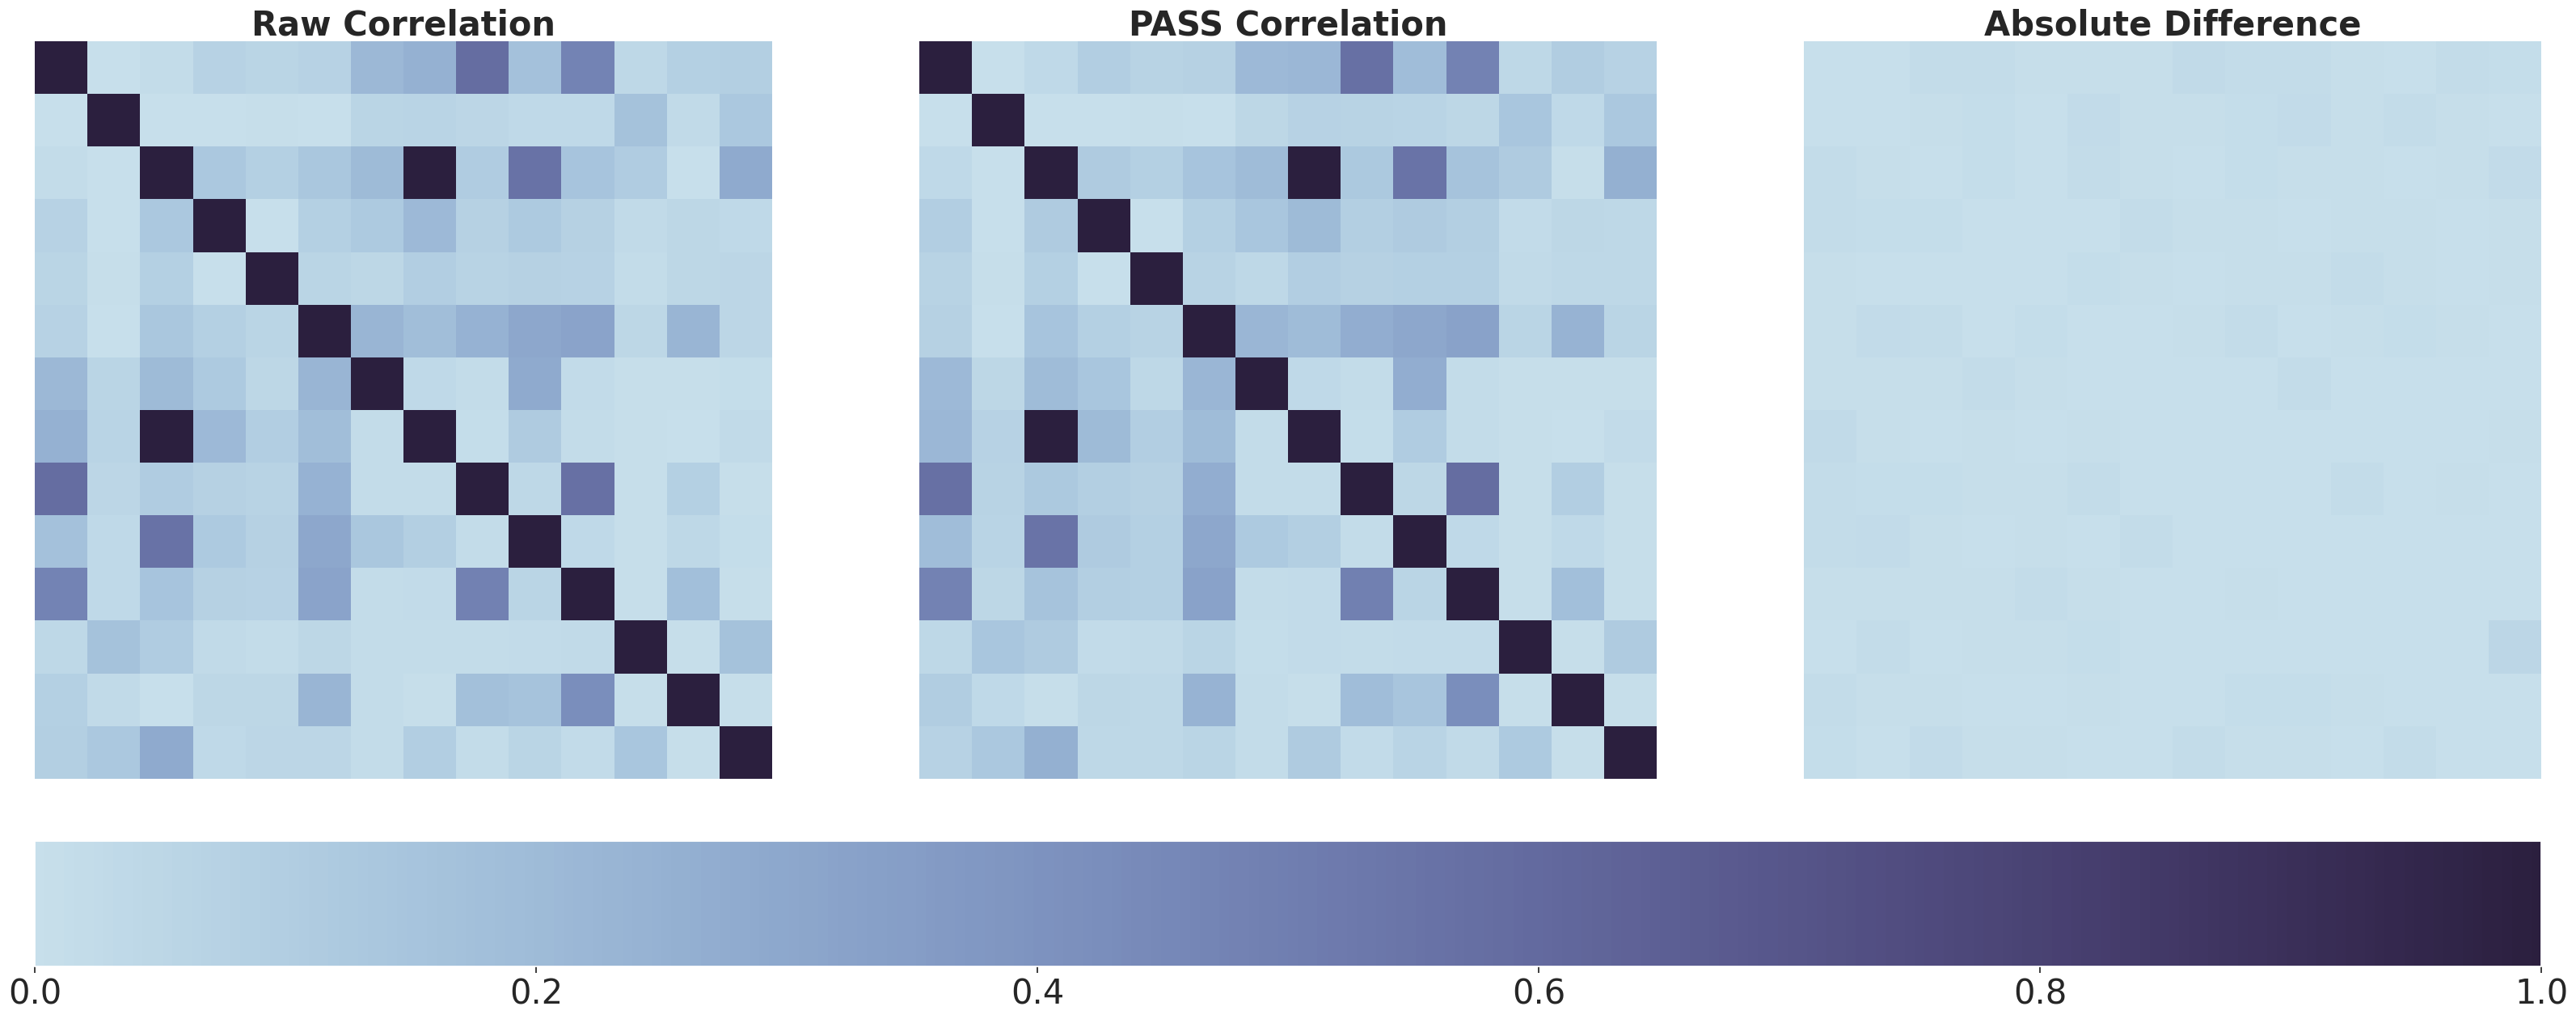

In [10]:
temp_truedf = truedf.drop(columns=['y', 'type']).copy()
temp_fakedf = fakedf.drop(columns=['y', 'type']).copy()


true_corr = associations(temp_truedf, nom_nom_assoc='theil', annot=False, cmap='Blues', plot=False)['corr']
fake_corr = associations(temp_fakedf, nom_nom_assoc='theil', annot=False, cmap='Blues', plot=False)['corr']
diff_corr = np.abs(true_corr - fake_corr)
# heatmaps
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True, n_colors=100)


kwargs = {
    'cmap': cmap,
    'annot': False,
    'xticklabels': False,
    'yticklabels': False,
    'cbar': False,
    'square': True,
    'vmin': 0,
    'vmax': 1
}

plt.subplots(figsize=(40, 20))


ax1 = plt.subplot(1, 3, 1)
img = sns.heatmap(true_corr, **kwargs, ax=ax1)
ax1.set_title('Raw Correlation', weight='bold', fontsize=30)


ax2 = plt.subplot(1, 3, 2)
sns.heatmap(fake_corr, **kwargs, ax=ax2)
ax2.set_title('PASS Correlation', weight='bold', fontsize=30)

ax3 = plt.subplot(1, 3, 3)
sns.heatmap(diff_corr, **kwargs, ax=ax3)
ax3.set_title('Absolute Difference', weight='bold', fontsize=30)

mappable = img.get_children()[0]
cbar = plt.colorbar(mappable, ax = [ax1, ax2, ax3], orientation = 'horizontal', pad=0.05)
cbar.ax.tick_params(labelsize=30)

plt.show()



# Savme comparisons, but with different labels and titles

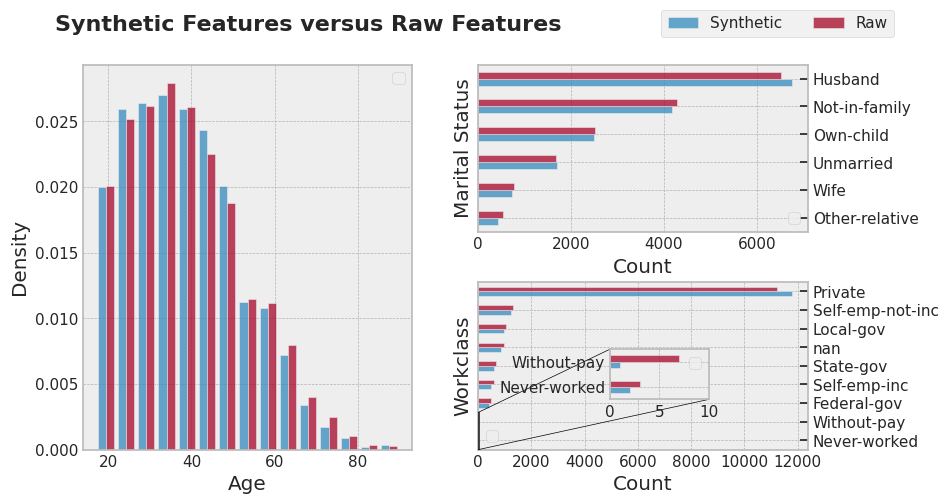

In [36]:
plt.style.use('bmh')
alpha = 0.75

fig = plt.figure(figsize=(30, 10))

 
ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=1, rowspan=2)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 1))
ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1))

ax1.hist([fakedf['x_num_0'], truedf['x_num_0']], label=['Synthetic', 'Raw'], density=True, alpha=alpha, bins=15)
ax1.set_xlabel('Age')
ax1.set_ylabel('Density')
ax1.legend('')

(mydf
 .filter(['x_cat_4', 'type'])
 .pivot_table(index=['x_cat_4'], aggfunc='size', columns='type')
 .sort_values(by='Raw')
 .plot.barh(figsize=(10, 5), ax=ax2, alpha=alpha)
)
ax2.set_xlabel('Count')
ax2.set_ylabel('Marital Status')
ax2.legend('')
ax2.yaxis.tick_right()


(mydf
 .filter(['x_cat_0', 'type'])
 .pivot_table(index=['x_cat_0'], aggfunc='size', columns='type')
 .sort_values(by='Raw')
 .plot.barh(figsize=(10, 5), ax=ax3, alpha=alpha)
)
ax3.set_xlabel('Count')
ax3.set_ylabel('Workclass')
ax3.legend('')
ax3.yaxis.tick_right()


axins = ax3.inset_axes([0.4, 0.3, 0.3, 0.3])
  
(mydf
 .filter(['x_cat_0', 'type'])
 .pivot_table(index=['x_cat_0'], aggfunc='size', columns='type')
 .sort_values(by='Raw')
 .plot.barh(figsize=(10, 5), ax=axins, alpha=alpha)
)
axins.legend('')
axins.set_xlim(0, 10)
axins.set_ylim(-0.5, 1.5)
axins.set_xlabel('')
axins.set_ylabel('')
# axins.yaxis.tick_right()
  
ax3.indicate_inset_zoom(axins, alpha=1, edgecolor="black")


handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=[0.82, 0.92])


plt.suptitle('Synthetic Features versus Raw Features', weight='bold', fontsize=16, x=0.35)

# set the spacing between subplots
plt.subplots_adjust(
    right = 0.85,
    hspace = 0.3,   # the amount of height reserved for white space between subplots
)

# plt.show()
plt.savefig('/home/liu00980/Documents/multimodal/tabular/tab-ddpm/pass-inference/feature-comparison.pdf')

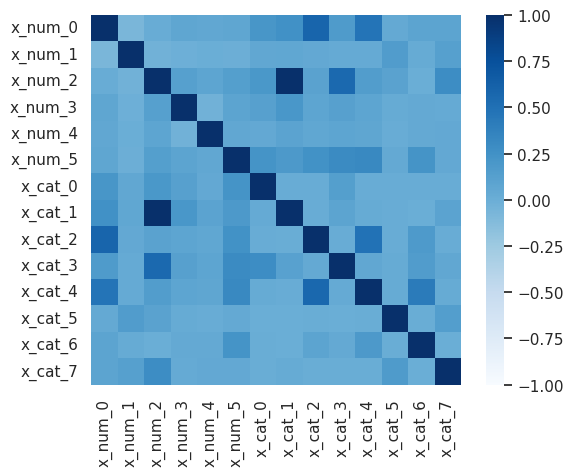

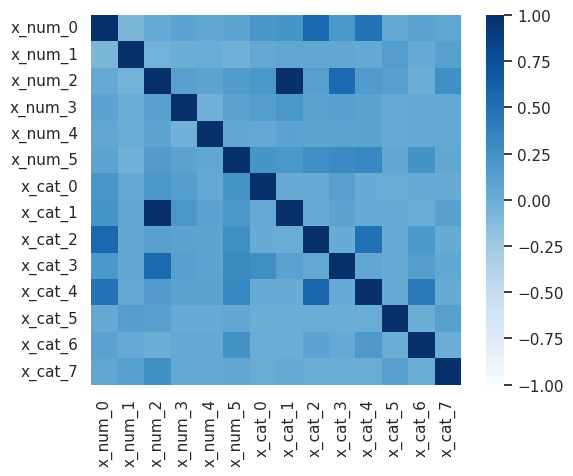

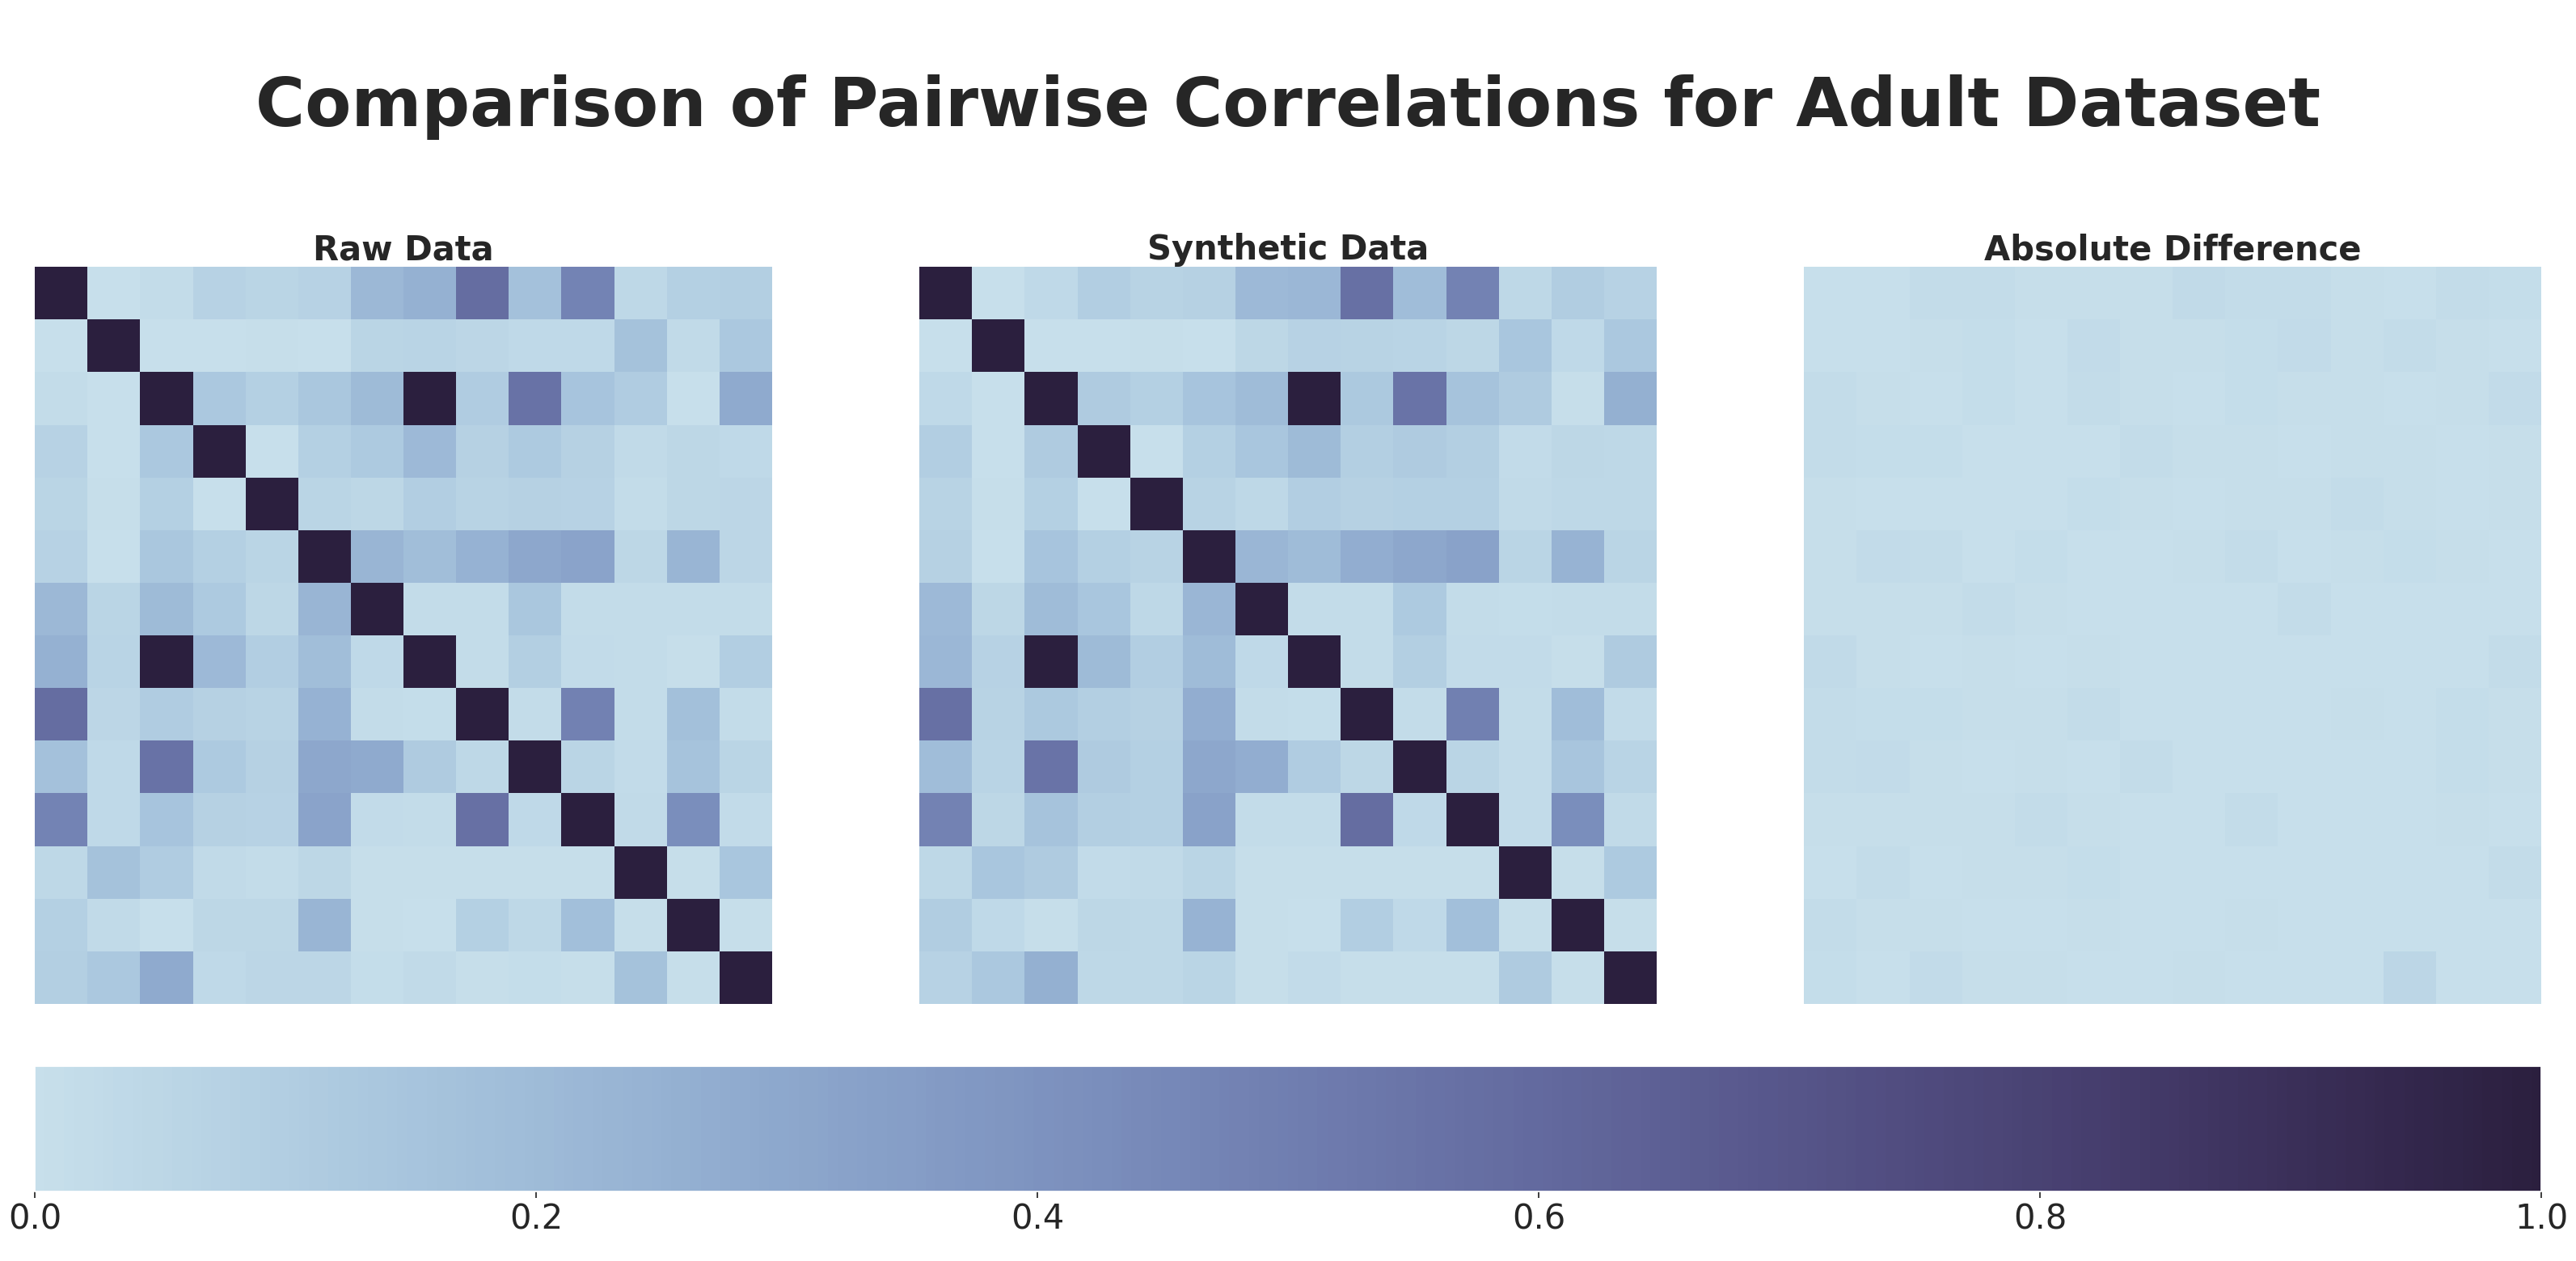

In [34]:
temp_truedf = truedf.drop(columns=["y", "type"]).copy()
temp_fakedf = fakedf.drop(columns=["y", "type"]).copy()


true_corr = associations(
    temp_truedf,
    theil_u=True,
    annot=False,
    cmap="Blues",
    plot=False,
    nan_strategy="drop_samples",
)["corr"]
fake_corr = associations(
    temp_fakedf,
    theil_u=True,
    annot=False,
    cmap="Blues",
    plot=False,
    nan_strategy="drop_samples",
)["corr"]
diff_corr = np.abs(true_corr - fake_corr)
# heatmaps
sns.set(rc={"axes.facecolor": "white", "figure.facecolor": "white"})
cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True, n_colors=100)


kwargs = {
    "cmap": cmap,
    "annot": False,
    "xticklabels": False,
    "yticklabels": False,
    "cbar": False,
    "square": True,
    "vmin": 0,
    "vmax": 1,
}

fig, axs = plt.subplots(figsize=(40, 20))


ax1 = plt.subplot(1, 3, 1)
img = sns.heatmap(true_corr, **kwargs, ax=ax1)
ax1.set_title("Raw Data", weight="bold", fontsize=30)


ax2 = plt.subplot(1, 3, 2)
sns.heatmap(fake_corr, **kwargs, ax=ax2)
ax2.set_title("Synthetic Data", weight="bold", fontsize=30)

ax3 = plt.subplot(1, 3, 3)
sns.heatmap(diff_corr, **kwargs, ax=ax3)
ax3.set_title("Absolute Difference", weight="bold", fontsize=30)

mappable = img.get_children()[0]
cbar = plt.colorbar(mappable, ax=[ax1, ax2, ax3], orientation="horizontal", pad=0.05)
cbar.ax.tick_params(labelsize=30)

axs.axis("off")
axs.set_title("Comparison of Pairwise Correlations for Adult Dataset", weight="bold", fontsize=60, y=0.9)


plt.show()